In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import collections

from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Proposed Model

In [24]:
PATH = '../results/proposed-model/metrics/'

In [32]:
maxiter = 11
output = {}
for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
    for embedding in ['word2vec', 'fasttext']:
        for it in range(1, maxiter):
            out = pd.read_pickle(PATH+f'GRU-256-{embedding}-{task}-{it}-new-cnn-.p')
            output[task+'-'+embedding+'-'+str(it)] = out

In [33]:
out_df = pd.DataFrame(output).transpose().reset_index()

In [34]:
out_df['task'] = out_df['index'].str.split('-', expand=True)[0]
out_df['embedding'] = out_df['index'].str.split('-', expand=True)[1]
out_df['iter'] = out_df['index'].str.split('-', expand=True)[2]

In [35]:
display(out_df)

,index,auc,auprc,acc,F1,task,embedding,iter
0,los_3-word2vec-1,0.696617,0.635054,0.655924,0.540606,los_3,word2vec,1
1,los_3-word2vec-2,0.695168,0.638569,0.658420,0.528361,los_3,word2vec,2
2,los_3-word2vec-3,0.707778,0.649534,0.667272,0.536369,los_3,word2vec,3
3,los_3-word2vec-4,0.690429,0.627395,0.653427,0.521766,los_3,word2vec,4
4,los_3-word2vec-5,0.697894,0.639008,0.667045,0.560120,los_3,word2vec,5
...,...,...,...,...,...,...,...,...
75,mort_icu-fasttext-6,0.526370,0.076079,0.266909,0.138207,mort_icu,fasttext,6
76,mort_icu-fasttext-7,0.826238,0.445460,0.935996,0.261780,mort_icu,fasttext,7
77,mort_icu-fasttext-8,0.496267,0.071507,0.266909,0.128440,mort_icu,fasttext,8
78,mort_icu-fasttext-9,0.515817,0.073050,0.537676,0.123871,mort_icu,fasttext,9


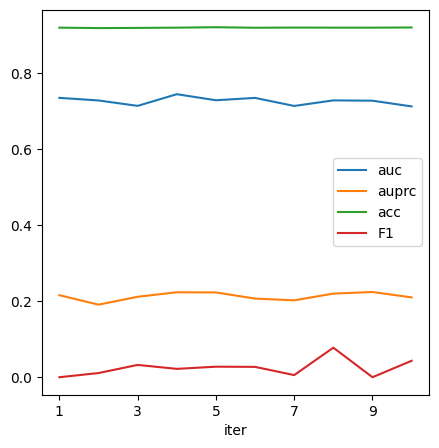

In [48]:
out_df[(out_df['task']=='los_7') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

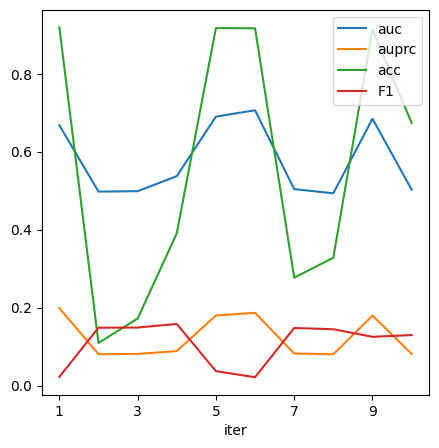

In [49]:
out_df[(out_df['task']=='los_7') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

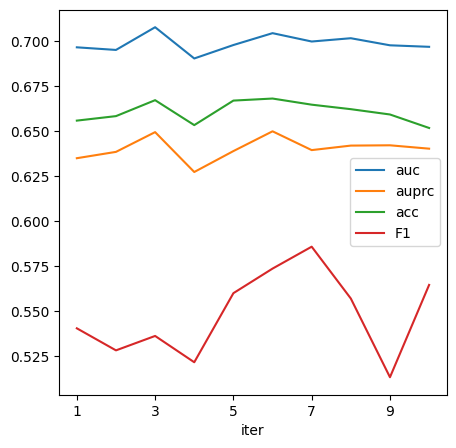

In [50]:
out_df[(out_df['task']=='los_3') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

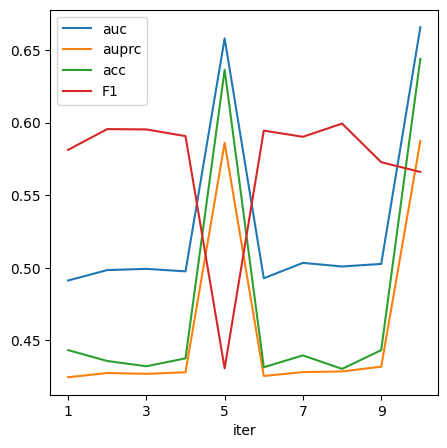

In [51]:
out_df[(out_df['task']=='los_3') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

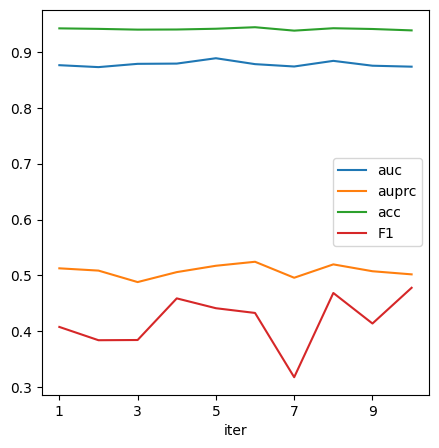

In [52]:
out_df[(out_df['task']=='mort_icu') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

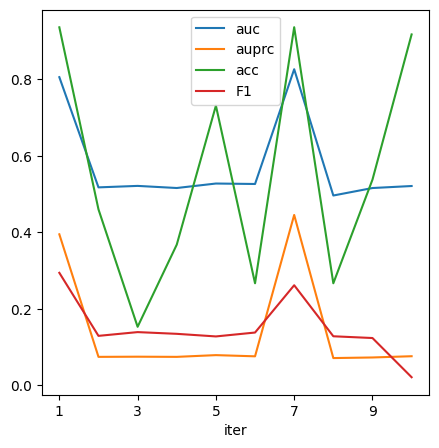

In [53]:
out_df[(out_df['task']=='mort_icu') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

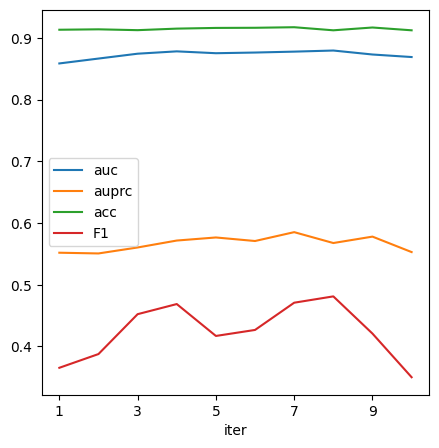

In [54]:
out_df[(out_df['task']=='mort_hosp') &  (out_df['embedding'] == 'word2vec')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

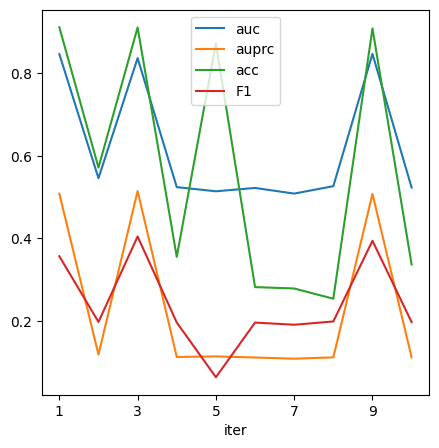

In [55]:
out_df[(out_df['task']=='mort_hosp') &  (out_df['embedding'] == 'fasttext')].plot(x="iter", y=["auc","auprc","acc","F1"], kind="line", figsize=(5,5))
plt.show()

In [56]:
max_score = {}
for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
    for embedding in ['word2vec','fasttext']:
        ind = out_df[(out_df['task']==task) & (out_df['embedding']==embedding)]['auc'].argmax()
        score = out_df[(out_df['task']==task) & (out_df['embedding']==embedding)].iloc[ind][['auc', 'auprc', 'acc', 'F1']].to_dict()
        max_score[task+'-'+embedding] = score

In [57]:
pd.DataFrame(max_score).transpose()

,auc,auprc,acc,F1
los_3-word2vec,0.707778,0.649534,0.667272,0.536369
los_3-fasttext,0.665684,0.587367,0.643895,0.565975
los_7-word2vec,0.744186,0.223386,0.919201,0.021978
los_7-fasttext,0.706350,0.186583,0.916704,0.021333
mort_hosp-word2vec,0.879615,0.567645,0.912392,0.481183
mort_hosp-fasttext,0.846861,0.507479,0.908534,0.393985
mort_icu-word2vec,0.889044,0.517128,0.941897,0.441048
mort_icu-fasttext,0.826238,0.445460,0.935996,0.261780


In [58]:
pd.DataFrame(max_score).transpose().to_csv('../results/proposed-model/metrics/best_scores.csv')

# Baseline

In [3]:
PATH = '../results/timeseries-baseline/metrics/'

In [4]:
maxiter = 11
output = {}
for model in ['GRU', 'LSTM']:
    for size in [128, 256]:
        for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
            for it in range(1, maxiter):
                out = pd.read_pickle(PATH+f'{size}-{model}-{task}-{it}-new.p')
                output['-'.join([str(size), model, task, str(it)])] = out

In [5]:
bl_outdf = pd.DataFrame(output).transpose()
bl_outdf = bl_outdf.reset_index()

In [6]:
bl_outdf['index'].str.split('-', expand=True)

,0,1,2,3
0,128,GRU,los_3,1
1,128,GRU,los_3,2
2,128,GRU,los_3,3
3,128,GRU,los_3,4
4,128,GRU,los_3,5
...,...,...,...,...
155,256,LSTM,mort_icu,6
156,256,LSTM,mort_icu,7
157,256,LSTM,mort_icu,8
158,256,LSTM,mort_icu,9


In [7]:
bl_outdf['hidden_unit'] = bl_outdf['index'].str.split('-', expand=True)[0]
bl_outdf['model'] = bl_outdf['index'].str.split('-',  expand=True)[1]
bl_outdf['task'] = bl_outdf['index'].str.split('-',  expand=True)[2]
bl_outdf['iter'] = bl_outdf['index'].str.split('-',  expand=True)[3]

In [19]:
print(bl_outdf)

                    index       auc     auprc       acc        F1 hidden_unit  \
0         128-GRU-los_3-1  0.692213  0.641977  0.661825  0.554159         128   
1         128-GRU-los_3-2  0.694263  0.637183  0.662279  0.551807         128   
2         128-GRU-los_3-3  0.687500  0.629461  0.657512  0.570453         128   
3         128-GRU-los_3-4  0.690616  0.631797  0.657286  0.545728         128   
4         128-GRU-los_3-5  0.701538  0.642738  0.666364  0.562760         128   
..                    ...       ...       ...       ...       ...         ...   
155   256-LSTM-mort_icu-6  0.879490  0.465627  0.935089  0.347032         256   
156   256-LSTM-mort_icu-7  0.882524  0.508054  0.941217  0.423163         256   
157   256-LSTM-mort_icu-8  0.887754  0.504423  0.940309  0.378251         256   
158   256-LSTM-mort_icu-9  0.880689  0.502082  0.940763  0.410835         256   
159  256-LSTM-mort_icu-10  0.879466  0.484076  0.938039  0.357647         256   

    model      task iter  


In [8]:
bl_score = {}
for model in ['GRU', 'LSTM']:
        for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
            sub_df = bl_outdf[(bl_outdf['model']==model) & (bl_outdf['task']==task)]
            ind = sub_df['auc'].argmax()
            bl_score['-'.join([model, task])] = sub_df.iloc[ind]

In [10]:
ts_baseline_df = pd.DataFrame(bl_score).transpose().sort_values('task')

In [11]:
ts_baseline_df.to_csv('../results/timeseries-baseline/metrics/best_scores.csv')

In [21]:
display(ts_baseline_df)

,index,auc,auprc,acc,F1,hidden_unit,model,task,iter
GRU-los_3,128-GRU-los_3-5,0.701538,0.642738,0.666364,0.56276,128,GRU,los_3,5
LSTM-los_3,128-LSTM-los_3-4,0.696343,0.633673,0.658193,0.5369,128,LSTM,los_3,4
GRU-los_7,256-GRU-los_7-2,0.747498,0.221757,0.91852,0.047745,256,GRU,los_7,2
LSTM-los_7,256-LSTM-los_7-8,0.739706,0.204073,0.918747,0.01105,256,LSTM,los_7,8
GRU-mort_hosp,256-GRU-mort_hosp-9,0.884279,0.564403,0.912846,0.440233,256,GRU,mort_hosp,9
LSTM-mort_hosp,256-LSTM-mort_hosp-8,0.879725,0.558737,0.916931,0.45045,256,LSTM,mort_hosp,8
GRU-mort_icu,128-GRU-mort_icu-8,0.891895,0.520284,0.940082,0.440678,128,GRU,mort_icu,8
LSTM-mort_icu,128-LSTM-mort_icu-8,0.893798,0.513111,0.941897,0.415525,128,LSTM,mort_icu,8


# Multimodal Baseline

In [3]:
PATH = '../results/multimodal-baseline/metrics/'

In [4]:
maxiter = 11
output = {}

for size in [128]:
    for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
            for embedding in ['word2vec', 'fasttext']:
                out = pd.read_pickle(PATH+f'GRU-{size}-{embedding}-{task}-1-new-avg-.p')
                output['-'.join([str(size), task, embedding])] = out

In [5]:
blavg_outdf = pd.DataFrame(output).transpose()
blavg_outdf = blavg_outdf.reset_index()

In [11]:
blavg_outdf['hidden_unit'] = blavg_outdf['index'].str.split('-', expand=True)[0]
blavg_outdf['task'] = blavg_outdf['index'].str.split('-', expand=True)[1]
blavg_outdf['embedding'] = blavg_outdf['index'].str.split('-', expand=True)[2]

In [12]:
print(blavg_outdf)

                    index       auc     auprc       acc        F1 hidden_unit  \
0      128-los_3-word2vec  0.699888  0.635958  0.658193  0.550984         128   
1      128-los_3-fasttext  0.701458  0.639835  0.659101  0.543465         128   
2      128-los_7-word2vec  0.728715  0.198856  0.919201  0.021978         128   
3      128-los_7-fasttext  0.733847  0.209850  0.918747  0.016484         128   
4  128-mort_hosp-word2vec  0.876083  0.563756  0.917612  0.455772         128   
5  128-mort_hosp-fasttext  0.875780  0.572785  0.912165  0.464730         128   
6   128-mort_icu-word2vec  0.875654  0.520622  0.941217  0.366748         128   
7   128-mort_icu-fasttext  0.889871  0.524439  0.942805  0.429864         128   

        task embedding  
0      los_3  word2vec  
1      los_3  fasttext  
2      los_7  word2vec  
3      los_7  fasttext  
4  mort_hosp  word2vec  
5  mort_hosp  fasttext  
6   mort_icu  word2vec  
7   mort_icu  fasttext  


In [13]:
max_score = {}
for task in ['los_3', 'los_7', 'mort_hosp', 'mort_icu']:
    for embedding in ['word2vec','fasttext']:
        ind = blavg_outdf[(blavg_outdf['task']==task) & (blavg_outdf['embedding']==embedding)]['auc'].argmax()
        score = blavg_outdf[(blavg_outdf['task']==task) & (blavg_outdf['embedding']==embedding)].iloc[ind][['auc', 'auprc', 'acc', 'F1']].to_dict()
        max_score[task+'-'+embedding] = score

In [117]:
pd.DataFrame(max_score).transpose()

,index,auc,auprc,acc,F1,hidden_unit,task
los_3,256-los_3,0.705491,0.64384,0.662443,0.549517,256,los_3
los_7,128-los_7,0.736769,0.231613,0.920362,0.043478,128,los_7
mort_hosp,128-mort_hosp,0.886318,0.597724,0.919457,0.48105,128,mort_hosp
mort_icu,128-mort_icu,0.894676,0.539072,0.945475,0.455982,128,mort_icu


In [14]:
pd.DataFrame(max_score).transpose().to_csv('../results/multimodal-baseline/metrics/best_scores.csv')